In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(0)

In [2]:
def change_dates(df):
    #changes fecha_inicio_sintomas according to new criteria
    filt_df2 = (df.fecha_inicio_sintomas.isnull()) #filter fecha_inicio_sintomas = inexistant
    n_size = (df[filt_df2]).shape[0]
    df["fecha_inicio_sintomas"] = df["fecha_inicio_sintomas"].fillna(0)
    df["fecha_inicio_sintomas"] = df["fecha_inicio_sintomas"].astype('int')
    df["fecha_apertura"] = df["fecha_apertura"].astype('int')
    b = np.array(df["fecha_apertura"].values)
    a = np.array(df["fecha_inicio_sintomas"].values)
    a[filt_df2.values] = b[filt_df2.values] - np.random.randint(0,9,a[filt_df2.values].shape)
    filt_a = np.where(a<0)
    a[filt_a] = 0
    df = df.drop(["fecha_inicio_sintomas"],axis=1)
    df["fecha_inicio_sintomas"] = a
    return df

## Carga de datos, sacamos las series temporal

In [3]:
direccion = '12en20.csv'
columnas = ['residencia_provincia_nombre','residencia_departamento_nombre','fecha_inicio_sintomas',
            'fecha_apertura','clasificacion_resumen']
data = pd.read_csv(direccion,sep=",",quotechar='"', usecols=columnas,
                   parse_dates=["fecha_inicio_sintomas","fecha_apertura"],na_values=['']) 

In [4]:
data = data[data["clasificacion_resumen"] == "Confirmado"] #filter confirmed cases
df = pd.DataFrame(data) 

In [5]:
df = df.drop(['clasificacion_resumen'], axis=1) #drop clasificacion_resumen bc previous filter of confirmed cases

In [6]:
filt_df1 = (df.fecha_inicio_sintomas.notnull()) #filter fecha_inicio_sintomas = inexistant
inicio_epidemia = (df.loc[filt_df1,"fecha_inicio_sintomas"]).min() #first symptoms of a person registered
ultima_actualizacion_sintomas = (df.loc[filt_df1,"fecha_inicio_sintomas"]).max() #last day symptoms of a person registered
ultima_actualizacion_apertura = (df["fecha_apertura"]).max()
df["fecha_inicio_sintomas"] -= inicio_epidemia #correcting by inicio_epidemia 
df["fecha_apertura"] -= inicio_epidemia #correcting by inicio_epidemia
df.fecha_inicio_sintomas = df.fecha_inicio_sintomas.dt.days #change to int, ditch days 
df.fecha_apertura = df.fecha_apertura.dt.days #change to int, ditch days
print("primer sintoma de persona confirmada: ",inicio_epidemia)
print("ultimo sintoma de persona confirmada: ",ultima_actualizacion_sintomas)
print("ultima apertura de persona confirmada: ",ultima_actualizacion_apertura)

primer sintoma de persona confirmada:  2020-01-01 00:00:00
ultimo sintoma de persona confirmada:  2021-01-11 00:00:00
ultima apertura de persona confirmada:  2021-01-11 00:00:00


In [7]:
df = change_dates(df) # we have replaced all bad or undefined dates

In [8]:
df = df[["residencia_provincia_nombre","fecha_inicio_sintomas"]]
df2 = df.groupby(["residencia_provincia_nombre","fecha_inicio_sintomas"]).size().reset_index() 
df2 = df2.rename(columns={0:'casos'})
df3 = df2.sort_values(["residencia_provincia_nombre","fecha_inicio_sintomas"],ascending=[True,True])

In [9]:
#let's list all the provinces that have cases (all rn tbh, but just to use pandas stuff)
#we'll get those times series then, with pd grouping
provincias = pd.Series(df3["residencia_provincia_nombre"].unique())
#print: we get provinces + the sin especificar / unespecified thing
print(provincias)

0            Buenos Aires
1                    CABA
2               Catamarca
3                   Chaco
4                  Chubut
5              Corrientes
6                 Córdoba
7              Entre Ríos
8                 Formosa
9                   Jujuy
10               La Pampa
11               La Rioja
12                Mendoza
13               Misiones
14                Neuquén
15              Río Negro
16        SIN ESPECIFICAR
17                  Salta
18               San Juan
19               San Luis
20             Santa Cruz
21               Santa Fe
22    Santiago del Estero
23       Tierra del Fuego
24                Tucumán
dtype: object


In [10]:
rows = provincias.shape[0]
cols = df2["fecha_inicio_sintomas"].max()
time_series = np.zeros(shape=(rows,cols+1))
time_series_ac = np.zeros(shape=(rows,cols+1))

In [11]:
time_series[0,376]

0.0

In [12]:
j = 0
for i in provincias:
  df_tmp = df3[df3["residencia_provincia_nombre"]==i]
  tmp_dates = np.array(df_tmp["fecha_inicio_sintomas"].values)
  tmp_cases = np.array(df_tmp["casos"].values)
  time_series[j,tmp_dates]= tmp_cases
  j = j + 1

In [13]:
for i in range(rows):
  for j in range(13,cols):
    time_series_ac[i,j] = np.sum(time_series[i,j-13:j+1])

## Primero, aca vamos a calcular la correlacion de Pearson y chequear que de todo bien

Esto funciona aca y esta todo tranquilo, no hay problema!

In [14]:
#no existe en cupy, la hago yo a esta funcion 
def pearsonr(a,b):
  m_a = np.mean(a)
  m_b = np.mean(b)
  r_a = a - m_a
  r_b = b - m_b
  r_a_2 = np.sum((r_a)**2) 
  r_b_2 = np.sum((r_b)**2)
  r = np.sum((r_a*r_b)/np.sqrt(r_a_2*r_b_2))
  return r

In [15]:
#por ejemplo, correlaciones para caba y baires
caba = time_series_ac[1,:-10]
baires = time_series_ac[0,:-10]
pearsonr(caba,baires)

0.8835980972575199

In [16]:
#ahora, tratemos de hacer lo mismo para baires y el resto del país
baires = time_series_ac[0,:-10]
i = 1
provs = provincias
print('Coeficientes de Pearson')
while i < rows:
  prov_tmp = time_series_ac[i,:-10]
  r = pearsonr(baires,prov_tmp)
  print('Pearson entre '+provs[i]+' y Baires: ',np.around(r,3))
  i += 1

Coeficientes de Pearson
Pearson entre CABA y Baires:  0.884
Pearson entre Catamarca y Baires:  0.317
Pearson entre Chaco y Baires:  0.604
Pearson entre Chubut y Baires:  0.5
Pearson entre Corrientes y Baires:  0.185
Pearson entre Córdoba y Baires:  0.611
Pearson entre Entre Ríos y Baires:  0.578
Pearson entre Formosa y Baires:  0.326
Pearson entre Jujuy y Baires:  0.867
Pearson entre La Pampa y Baires:  0.261
Pearson entre La Rioja y Baires:  0.836
Pearson entre Mendoza y Baires:  0.792
Pearson entre Misiones y Baires:  0.168
Pearson entre Neuquén y Baires:  0.645
Pearson entre Río Negro y Baires:  0.738
Pearson entre SIN ESPECIFICAR y Baires:  0.722
Pearson entre Salta y Baires:  0.824
Pearson entre San Juan y Baires:  0.243
Pearson entre San Luis y Baires:  0.39
Pearson entre Santa Cruz y Baires:  0.472
Pearson entre Santa Fe y Baires:  0.634
Pearson entre Santiago del Estero y Baires:  0.509
Pearson entre Tierra del Fuego y Baires:  0.64
Pearson entre Tucumán y Baires:  0.599


## Segundo, la Time Lagged Cross Correlation

Chequee aca que el problema es efectivamente el padding para calcular esto, que queda cero en el denominador y queda nan, si lo saco entonces se observa que no hay problema. Sin embargo, no pasa lo mismo con las funciones de cupy, asi que tiene que haber un problema del que no me estaria dando mucha cuenta.

In [17]:
#no existe en cupy, la hago yo a esta funcion 
def pearsonr2(a,b):
  m_a = np.mean(a)
  m_b = np.mean(b)
  r_a = a - m_a
  r_b = b - m_b
  r_a_2 = np.sum((r_a)**2) 
  r_b_2 = np.sum((r_b)**2)
  r = np.sum((r_a*r_b))
  return r

In [18]:
def lag_pearson(a,b,lag):
  #dejo a fijo
  #desplazo b
  b = np.roll(b,lag)
  r = pearsonr2(a[lag:],b[lag:])
  return r

In [19]:
#ahora, tratemos de hacer lo mismo para baires y el resto del país
baires = time_series_ac[0,:-10]
offset_vec = []
rs_vec = []
seconds = 5
fps = 20
i = 1
while i < rows:
  prov_tmp = time_series_ac[i,:-10]
  rs = [lag_pearson(baires,prov_tmp,lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
  rs = np.array(rs)
  #print(rs)
  offset_tmp = np.floor(len(rs)/2)-np.argmax(rs)
  rs_tmp = np.max(rs)
  offset_vec.append(offset_tmp)
  rs_vec.append(rs_tmp)
  print('Pearson máx entre '+provs[i]+' y Baires: ',np.around(rs_tmp,3),'. En offset de frames: ',offset_tmp)
  i = i + 1

Pearson máx entre CABA y Baires:  55770808686.0 . En offset de frames:  -21.0
Pearson máx entre Catamarca y Baires:  523677950.387 . En offset de frames:  0.0
Pearson máx entre Chaco y Baires:  5738900765.139 . En offset de frames:  0.0
Pearson máx entre Chubut y Baires:  8924330861.956 . En offset de frames:  0.0
Pearson máx entre Corrientes y Baires:  1489599696.738 . En offset de frames:  0.0
Pearson máx entre Córdoba y Baires:  44911305997.471 . En offset de frames:  0.0
Pearson máx entre Entre Ríos y Baires:  8188226071.91 . En offset de frames:  0.0
Pearson máx entre Formosa y Baires:  38554456.366 . En offset de frames:  -80.0
Pearson máx entre Jujuy y Baires:  9737923560.26 . En offset de frames:  -5.0
Pearson máx entre La Pampa y Baires:  1935514786.891 . En offset de frames:  0.0
Pearson máx entre La Rioja y Baires:  4130027540.226 . En offset de frames:  0.0
Pearson máx entre Mendoza y Baires:  26591380382.847 . En offset de frames:  0.0
Pearson máx entre Misiones y Baires: 

## Pruebo aca usar el correlate de Cupy, con lag y todo, verificamos que funciona okay. 

In [20]:
baires = time_series_ac[0,:-10]
caba = time_series_ac[1,:-10]

In [21]:
npts = baires.shape[0]
lags = np.arange(-npts + 1, npts)

In [22]:
ccov = np.correlate(baires - baires.mean(), caba - caba.mean(), mode='full')
ccor = ccov / (npts * baires.std() * caba.std())

max correlation is 0.940944
max correlation is at lag 21


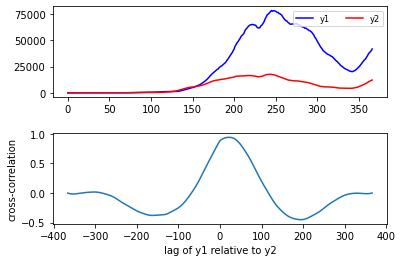

In [23]:
fig, axs = plt.subplots(nrows=2)
fig.subplots_adjust(hspace=0.4)
ax = axs[0]
ax.plot(baires, 'b', label='y1')
ax.plot(caba, 'r', label='y2')
ax.legend(loc='upper right', fontsize='small', ncol=2)

ax = axs[1]
ax.plot(lags, ccor)
ax.set_ylabel('cross-correlation')
ax.set_xlabel('lag of y1 relative to y2')

maxlag = lags[np.argmax(ccor)]
print("max correlation is %f" % np.max(ccor))
print("max correlation is at lag %d" % maxlag)

# Ahora, lo hacemos en serio, tipo todas las provincias contra todas las provincias, y guardamos los resultados

In [24]:
localidades_lagmax = np.zeros(shape=(rows,rows))
localidades_corrmax = np.zeros(shape=(rows,rows))
npts = cols
lags = np.arange(-npts + 1, npts)
i = 0
while i < rows:
    j = 0
    prov_tmp_1 = time_series_ac[i,:-10]
    while j < rows:
        prov_tmp_2 = time_series_ac[j,:-10]
        ccov = np.correlate(prov_tmp_1  - prov_tmp_1 .mean(), prov_tmp_2 - prov_tmp_2.mean(), mode='full')
        ccor = ccov / (npts * prov_tmp_1 .std() * prov_tmp_2.std())
        localidades_lagmax[i,j] = lags[np.argmax(ccor)]
        localidades_corrmax[i,j] = np.max(ccor)
        j = j + 1
    i = i +1

In [25]:
localidades_lagmax

array([[  -9.,   12.,  -76.,  -60.,  -67.,  -90.,  -51.,  -62.,  -54.,
          -3.,  -87.,  -24.,  -34., -106.,  -52.,  -49.,    9.,  -25.,
         -73.,  -62.,  -76.,  -53.,  -56.,  -49.,  -49.],
       [ -30.,   -9., -112.,  -88.,  -90., -115.,  -76.,  -88.,   18.,
         -22., -119.,  -53.,  -59., -119.,  -78.,  -75.,   -9.,  -51.,
        -107.,  -85.,  -98.,  -80.,  -85.,  -76.,  -75.],
       [  58.,   94.,   -9.,   12.,    4.,  -29.,   21.,    2.,   17.,
          63.,   -9.,   46.,   44.,   -9.,   14.,   13.,  100.,   45.,
          -9.,    2.,   -9.,   17.,   16.,   17.,   16.],
       [  42.,   70.,  -30.,   -9.,   -9.,  -11.,    9.,   -9.,   -9.,
          67.,  -32.,   27.,   25.,  -33.,   -9.,   -9.,   76.,   30.,
         -25.,    9.,   -9.,   -5.,   -4.,   -3.,   21.],
       [  49.,   72.,  -22.,   -9.,   -9.,  -47.,   -1.,   -9.,    5.,
          51.,  -12.,   23.,   20.,  -59.,   -7.,   -7.,   79.,   26.,
         -25.,  -14.,   -9.,   -1.,  -10.,   -5.,   -1.],


In [26]:
localidades_corrmax

array([[0.97606383, 0.9184217 , 0.82228916, 0.83523969, 0.88736131,
        0.77138569, 0.86590349, 0.86810543, 0.37328187, 0.85359997,
        0.73989153, 0.88096615, 0.88773059, 0.70560406, 0.88412792,
        0.89869673, 0.7955296 , 0.86409051, 0.78460991, 0.79361603,
        0.85823005, 0.90543205, 0.85570211, 0.84909012, 0.85529779],
       [0.9184217 , 0.97606383, 0.7688524 , 0.79053382, 0.84070435,
        0.72560034, 0.82044515, 0.829376  , 0.39104268, 0.83984467,
        0.73119644, 0.8414203 , 0.85514203, 0.7120952 , 0.8395007 ,
        0.85511524, 0.82306055, 0.81372216, 0.73988069, 0.74579328,
        0.80978288, 0.85523272, 0.82526205, 0.80131953, 0.80254378],
       [0.82228916, 0.7688524 , 0.97606383, 0.83169639, 0.874583  ,
        0.83155806, 0.87794614, 0.87443117, 0.49120157, 0.79421854,
        0.85679193, 0.84453499, 0.85586509, 0.7527869 , 0.84877372,
        0.83921114, 0.82257036, 0.85830218, 0.91238499, 0.83971994,
        0.8968055 , 0.87849922, 0.83332451, 0.